### Default Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup

%matplotlib inline

pd.set_option('display.max_columns', 500)

## Doing the modeling!

In [4]:
## define a function that will help me later
def null_checker(df):
    """Takes in dataframe and returns sorted list (descending) of columns with null values, and how many.
    """
    null_columns=df.columns[df.isnull().any()]
    return df[null_columns].isnull().sum().sort_values(ascending=False)

In [5]:
## taking in the new modeling DF with team info
merged = pd.read_csv('./data/merged_v4.csv')
merged.head()

,year,player,listed_pos,age,tm_name,g,gs,mp,per,ts%,3par,ftr,orb%,drb%,trb%,ast%,stl%,blk%,tov%,usg%,ows,dws,ws,ws/48,obpm,dbpm,bpm,vorp,fg,fga,fg%,3p,3pa,3p%,2p,2pa,2p%,efg%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,year-player,award_tm,award_pos,year-team,conference,losses,srs,wins
0,1989.0,kareem abdul-jabbar,C,41.0,LAL,74.0,74.0,1695.0,12.9,0.511,0.005,0.250,7.3,14.2,11.0,6.1,1.1,2.9,11.5,20.1,0.9,2.0,2.9,0.082,-2.3,0.0,-2.3,-0.1,313.0,659.0,0.475,0.0,3.0,0.000,313.0,656.0,0.477,0.475,122.0,165.0,0.739,103.0,231.0,334.0,74.0,38.0,85.0,95.0,196.0,748.0,1989.0kareem abdul-jabbar,0,C,1989.0LAL,West,25.0,6.38,57.0
1,1989.0,mark acres,C,26.0,BOS,62.0,0.0,632.0,8.2,0.507,0.009,0.421,10.9,15.6,13.3,3.7,1.5,0.6,14.5,10.4,0.4,0.5,0.9,0.066,-2.1,-0.4,-2.5,-0.1,55.0,114.0,0.482,1.0,1.0,1.000,54.0,113.0,0.478,0.487,26.0,48.0,0.542,59.0,87.0,146.0,19.0,19.0,6.0,23.0,94.0,137.0,1989.0mark acres,0,C,1989.0BOS,East,40.0,1.26,42.0
2,1989.0,michael adams,PG,26.0,DEN,77.0,77.0,2787.0,17.5,0.567,0.431,0.363,2.5,8.3,5.2,22.2,2.7,0.2,12.5,19.7,5.4,2.9,8.3,0.143,3.8,-0.6,3.2,3.7,468.0,1082.0,0.433,166.0,466.0,0.356,302.0,616.0,0.490,0.509,322.0,393.0,0.819,71.0,212.0,283.0,490.0,166.0,11.0,180.0,149.0,1424.0,1989.0michael adams,0,PG,1989.0DEN,West,38.0,0.91,44.0
3,1989.0,mark aguirre,SF,29.0,TOT,80.0,76.0,2597.0,16.4,0.524,0.137,0.309,6.4,10.0,8.3,17.9,0.9,0.8,12.6,27.4,2.4,2.1,4.5,0.082,1.7,-1.2,0.5,1.7,586.0,1270.0,0.461,51.0,174.0,0.293,535.0,1096.0,0.488,0.481,288.0,393.0,0.733,146.0,240.0,386.0,278.0,45.0,36.0,208.0,229.0,1511.0,1989.0mark aguirre,0,SF,1989.0TOT,TOT,48.0,0.19,34.0
4,1989.0,danny ainge,PG,29.0,TOT,73.0,54.0,2377.0,18.0,0.554,0.290,0.228,3.3,8.7,6.0,25.3,1.9,0.2,11.1,22.6,5.2,1.4,6.7,0.135,4.0,-1.6,2.3,2.6,480.0,1051.0,0.457,116.0,305.0,0.380,364.0,746.0,0.488,0.512,205.0,240.0,0.854,71.0,184.0,255.0,402.0,93.0,8.0,145.0,186.0,1281.0,1989.0danny ainge,0,PG,1989.0TOT,TOT,46.0,2.91,36.0


In [6]:
## create target label
merged['target'] = merged['award_tm'].map(lambda x: 1 if x > 0 else 0)

** Create `award_pos`, which is the positions that we're after **

In [7]:
awardpos_dict = {'C':'C',
                 'PG': 'G',
                 'SF':'F',
                 'PF':'F',
                 'SG': 'G',
                 'F':'F',
                 'G':'G'}

In [8]:
merged['award_pos'] = merged['award_pos'].apply(lambda x: awardpos_dict.get(x))

**Some data cleaning still!**
- Need to change some team names from expansion, moving, and other random team seasons to match

**Notes**
- Need to actually hold out a couple years fully for unseen data. So we'll have:
    - Train data (20)
    - Test data (6)
    - Holdout data (2)
- Look up `Categorical Encoder`

** Also for some reason the year 2000 is missing its target data. Fill it in!**

In [9]:
merged.loc[merged['year'] == 2000, 'target'].sum()

0

In [10]:
missing = {'shaquille o\'neal': 1, 
           'tim duncan': 1, 
           'kevin garnett': 1,
           'jason kidd': 1,
           'gary payton': 1,
           'alonzo mourning': 2, 
           'grant hill': 2, 
           'karl malone': 2,
           'kobe bryant': 2, 
           'allen iverson': 2, 
           'david robinson': 3, 
           'vince carter': 3,
           'chris webber': 3, 
           'eddie jones': 3, 
           'stephon marbury': 3}

Next, loop and add `target = 1` and `award_tm = missing.get('player')` for players in this list, for `year == 2000`

In [11]:
for player in list(missing.keys()):
    merged.loc[(merged['year'] == 2000) & (merged['player'] == player), 'award_tm'] = missing.get(player)
    merged.loc[(merged['year'] == 2000) & (merged['player'] == player), 'target'] = 1

In [12]:
## double check
merged[(merged['year'] == 2000) & merged['target']==1]

,year,player,listed_pos,age,tm_name,g,gs,mp,per,ts%,3par,ftr,orb%,drb%,trb%,ast%,stl%,blk%,tov%,usg%,ows,dws,ws,ws/48,obpm,dbpm,bpm,vorp,fg,fga,fg%,3p,3pa,3p%,2p,2pa,2p%,efg%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,year-player,award_tm,award_pos,year-team,conference,losses,srs,wins,target
4502,2000.0,kobe bryant,SG,21.0,LAL,66.0,62.0,2524.0,21.7,0.546,0.122,0.341,4.6,12.9,8.8,22.4,2.2,1.7,11.8,26.8,6.1,4.5,10.6,0.202,3.6,1.7,5.3,4.7,554.0,1183.0,0.468,46.0,144.0,0.319,508.0,1039.0,0.489,0.488,331.0,403.0,0.821,108.0,308.0,416.0,323.0,106.0,62.0,182.0,220.0,1485.0,2000.0kobe bryant,2,G,2000.0LAL,West,15.0,8.41,67.0,1
4516,2000.0,vince carter,SF,23.0,TOR,82.0,82.0,3126.0,23.4,0.543,0.139,0.325,5.2,12.1,8.5,20.5,1.8,2.1,8.4,30.0,9.1,2.7,11.8,0.182,5.2,-0.6,4.6,5.2,788.0,1696.0,0.465,95.0,236.0,0.403,693.0,1460.0,0.475,0.493,436.0,551.0,0.791,150.0,326.0,476.0,322.0,110.0,92.0,178.0,263.0,2107.0,2000.0vince carter,3,F,2000.0TOR,East,37.0,-0.46,45.0,1
4563,2000.0,tim duncan,PF,23.0,SAS,74.0,74.0,2875.0,24.8,0.555,0.009,0.471,10.8,24.8,18.1,15.5,1.2,4.0,13.5,28.7,6.7,6.4,13.0,0.218,2.6,3.5,6.1,5.9,628.0,1281.0,0.490,1.0,11.0,0.091,627.0,1270.0,0.494,0.491,459.0,603.0,0.761,262.0,656.0,918.0,234.0,66.0,165.0,242.0,210.0,1716.0,2000.0tim duncan,1,F,2000.0SAS,West,29.0,5.92,53.0,1
4586,2000.0,kevin garnett,PF,23.0,MIN,81.0,81.0,3243.0,23.6,0.545,0.053,0.265,7.9,26.6,17.1,21.5,1.9,2.8,13.6,27.4,6.1,5.6,11.6,0.172,3.1,3.0,6.1,6.6,759.0,1526.0,0.497,30.0,81.0,0.370,729.0,1445.0,0.504,0.507,309.0,404.0,0.765,223.0,733.0,956.0,401.0,120.0,126.0,268.0,205.0,1857.0,2000.0kevin garnett,1,F,2000.0MIN,West,32.0,2.67,50.0,1
4621,2000.0,grant hill,SF,27.0,DET,74.0,74.0,2776.0,24.5,0.565,0.069,0.425,4.1,16.4,10.2,26.8,1.9,1.1,12.4,30.5,8.1,2.6,10.7,0.185,4.6,0.2,4.8,4.7,696.0,1422.0,0.489,34.0,98.0,0.347,662.0,1324.0,0.500,0.501,480.0,604.0,0.795,97.0,393.0,490.0,385.0,103.0,43.0,240.0,190.0,1906.0,2000.0grant hill,2,F,2000.0DET,East,40.0,1.13,42.0,1
4633,2000.0,allen iverson,SG,24.0,PHI,70.0,70.0,2853.0,20.0,0.496,0.151,0.358,2.7,7.7,5.2,23.0,2.6,0.1,10.3,34.4,3.3,3.6,6.9,0.116,3.4,-0.8,2.6,3.3,729.0,1733.0,0.421,89.0,261.0,0.341,640.0,1472.0,0.435,0.446,442.0,620.0,0.713,71.0,196.0,267.0,328.0,144.0,5.0,230.0,162.0,1989.0,2000.0allen iverson,2,G,2000.0PHI,East,33.0,1.02,49.0,1
4652,2000.0,eddie jones,SG,28.0,CHA,72.0,72.0,2807.0,19.9,0.555,0.305,0.374,3.3,10.3,6.9,19.0,3.5,1.2,10.9,23.4,5.7,4.4,10.1,0.172,3.9,1.4,5.3,5.2,478.0,1119.0,0.427,128.0,341.0,0.375,350.0,778.0,0.450,0.484,362.0,419.0,0.864,81.0,262.0,343.0,305.0,192.0,49.0,160.0,176.0,1446.0,2000.0eddie jones,3,G,2000.0CHH,TOT,45.0,-6.62,37.0,1
4661,2000.0,jason kidd,PG,26.0,PHO,67.0,67.0,2616.0,18.4,0.498,0.194,0.287,4.2,16.1,10.3,40.1,2.6,0.8,19.0,20.0,3.7,4.8,8.5,0.156,1.7,2.4,4.1,4.1,350.0,855.0,0.409,56.0,166.0,0.337,294.0,689.0,0.427,0.442,203.0,245.0,0.829,96.0,387.0,483.0,678.0,134.0,28.0,226.0,148.0,959.0,2000.0jason kidd,1,G,2000.0PHO,West,29.0,5.24,53.0,1
4689,2000.0,karl malone,PF,36.0,UTA,82.0,82.0,2947.0,27.1,0.582,0.005,0.501,7.1,24.7,16.1,20.9,1.4,1.9,11.4,31.9,10.7,4.5,15.3,0.249,5.2,1.7,6.9,6.6,752.0,1476.0,0.509,2.0,8.0,0.250,750.0,1468.0,0.511,0.510,589.0,739.0,0.797,169.0,610.0,779.0,304.0,79.0,71.0,231.0,229.0,2095.0,2000.0karl malone,2,F,2000.0UTA,West,27.0,4.52,55.0,1
4692,2000.0,stephon marbury,PG,22.0,BRK,74.0,74.0,2881.0,20.7,0.528,0.177,0.407,2.3,7.2,4.6,39.0,2.0,0.4,14.8,28.2,6.1,1.2,7.4,0.123,4.1,-2.3,1.8,2.8,569.0,1317.0,0.432,66.0,233.0,0.283,503.0,1084.0,0.464,0.457,436.0,536.0,0.813,61.0,179.0,240.0,622.0,112.0,15.0,270.0,195.0,1640.0,2000.0stephon marbury,3,G,2000.0NJN,TOT,46.0,-1.94,36.0,1


In [13]:
## Set columns needed for per game
pergame_cols = ['mp', 'fg', 'fga', '2p', '2pa', 'ft', 'fta', 'orb', 'drb', 
                'trb','ast', 'stl', 'blk', 'tov', 'pf', 'pts']

for i in pergame_cols:
    colname = i + '_per_game'
    merged[colname] = merged[i] / merged['g']
    
merged.head()

,year,player,listed_pos,age,tm_name,g,gs,mp,per,ts%,3par,ftr,orb%,drb%,trb%,ast%,stl%,blk%,tov%,usg%,ows,dws,ws,ws/48,obpm,dbpm,bpm,vorp,fg,fga,fg%,3p,3pa,3p%,2p,2pa,2p%,efg%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,year-player,award_tm,award_pos,year-team,conference,losses,srs,wins,target,mp_per_game,fg_per_game,fga_per_game,2p_per_game,2pa_per_game,ft_per_game,fta_per_game,orb_per_game,drb_per_game,trb_per_game,ast_per_game,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game
0,1989.0,kareem abdul-jabbar,C,41.0,LAL,74.0,74.0,1695.0,12.9,0.511,0.005,0.250,7.3,14.2,11.0,6.1,1.1,2.9,11.5,20.1,0.9,2.0,2.9,0.082,-2.3,0.0,-2.3,-0.1,313.0,659.0,0.475,0.0,3.0,0.000,313.0,656.0,0.477,0.475,122.0,165.0,0.739,103.0,231.0,334.0,74.0,38.0,85.0,95.0,196.0,748.0,1989.0kareem abdul-jabbar,0,C,1989.0LAL,West,25.0,6.38,57.0,0,22.905405,4.229730,8.905405,4.229730,8.864865,1.648649,2.229730,1.391892,3.121622,4.513514,1.000000,0.513514,1.148649,1.283784,2.648649,10.108108
1,1989.0,mark acres,C,26.0,BOS,62.0,0.0,632.0,8.2,0.507,0.009,0.421,10.9,15.6,13.3,3.7,1.5,0.6,14.5,10.4,0.4,0.5,0.9,0.066,-2.1,-0.4,-2.5,-0.1,55.0,114.0,0.482,1.0,1.0,1.000,54.0,113.0,0.478,0.487,26.0,48.0,0.542,59.0,87.0,146.0,19.0,19.0,6.0,23.0,94.0,137.0,1989.0mark acres,0,C,1989.0BOS,East,40.0,1.26,42.0,0,10.193548,0.887097,1.838710,0.870968,1.822581,0.419355,0.774194,0.951613,1.403226,2.354839,0.306452,0.306452,0.096774,0.370968,1.516129,2.209677
2,1989.0,michael adams,PG,26.0,DEN,77.0,77.0,2787.0,17.5,0.567,0.431,0.363,2.5,8.3,5.2,22.2,2.7,0.2,12.5,19.7,5.4,2.9,8.3,0.143,3.8,-0.6,3.2,3.7,468.0,1082.0,0.433,166.0,466.0,0.356,302.0,616.0,0.490,0.509,322.0,393.0,0.819,71.0,212.0,283.0,490.0,166.0,11.0,180.0,149.0,1424.0,1989.0michael adams,0,G,1989.0DEN,West,38.0,0.91,44.0,0,36.194805,6.077922,14.051948,3.922078,8.000000,4.181818,5.103896,0.922078,2.753247,3.675325,6.363636,2.155844,0.142857,2.337662,1.935065,18.493506
3,1989.0,mark aguirre,SF,29.0,TOT,80.0,76.0,2597.0,16.4,0.524,0.137,0.309,6.4,10.0,8.3,17.9,0.9,0.8,12.6,27.4,2.4,2.1,4.5,0.082,1.7,-1.2,0.5,1.7,586.0,1270.0,0.461,51.0,174.0,0.293,535.0,1096.0,0.488,0.481,288.0,393.0,0.733,146.0,240.0,386.0,278.0,45.0,36.0,208.0,229.0,1511.0,1989.0mark aguirre,0,F,1989.0TOT,TOT,48.0,0.19,34.0,0,32.462500,7.325000,15.875000,6.687500,13.700000,3.600000,4.912500,1.825000,3.000000,4.825000,3.475000,0.562500,0.450000,2.600000,2.862500,18.887500
4,1989.0,danny ainge,PG,29.0,TOT,73.0,54.0,2377.0,18.0,0.554,0.290,0.228,3.3,8.7,6.0,25.3,1.9,0.2,11.1,22.6,5.2,1.4,6.7,0.135,4.0,-1.6,2.3,2.6,480.0,1051.0,0.457,116.0,305.0,0.380,364.0,746.0,0.488,0.512,205.0,240.0,0.854,71.0,184.0,255.0,402.0,93.0,8.0,145.0,186.0,1281.0,1989.0danny ainge,0,G,1989.0TOT,TOT,46.0,2.91,36.0,0,32.561644,6.575342,14.397260,4.986301,10.219178,2.808219,3.287671,0.972603,2.520548,3.493151,5.506849,1.273973,0.109589,1.986301,2.547945,17.547945


In [14]:
## save it!
merged.to_csv('./data/merged_v6.csv', index=False)

** Create our Train-Test-Split**

In [15]:
## gonna drop 1999 because of no all star game...
model_df = merged[merged['year'] != 1999]


train_yrs = [1989, 1990, 1991,
             1994, 1995,
             1997, 1998, 2000,
             2002, 2003, 2004,
             2006, 2007, 2008,
             2010, 2011, 2012,
             2014, 2015, 2016]
             
test_yrs = [1992,
            1996,
            2001,
            2005,
            2013,
            2017]

hold_yrs = [1993, 2009]

drop_cols = ['year', 'target', 'year-player', 'player', 'award_tm', 'listed_pos', 'year-team', 'losses']

X_train = model_df.drop(drop_cols, axis=1).loc[model_df['year'].isin(train_yrs)].reset_index(drop=True)
X_test = model_df.drop(drop_cols, axis=1).loc[model_df['year'].isin(test_yrs)].reset_index(drop=True)

y_train = model_df.loc[model_df['year'].isin(train_yrs), 'target']
y_test = model_df.loc[model_df['year'].isin(test_yrs), 'target']

X_hold = model_df.drop(drop_cols, axis=1).loc[model_df['year'].isin(hold_yrs)].reset_index(drop=True)
y_hold = model_df.loc[model_df['year'].isin(hold_yrs), 'target']

print('Train shapes',X_train.shape, y_train.shape)
print('Test shapes',X_test.shape, y_test.shape)
print('Hold shapes', X_hold.shape, y_hold.shape)

Train shapes (8786, 67) (8786,)
Test shapes (2701, 67) (2701,)
Hold shapes (844, 67) (844,)


### Start here!!
- model TTS starting point

In [16]:
## saving progress
# X_train.to_csv('./data/X_train.csv')
# X_test.to_csv('./data/X_test.csv')
# y_train.to_csv('./data/y_train.csv')
# y_test.to_csv('./data/y_test.csv')
# X_hold.to_csv('./data/X_hold.csv')
# y_hold.to_csv('./data/y_hold.csv')

# X_train = pd.read_csv('./data/X_train.csv', index_col=0)
# X_test = pd.read_csv('./data/X_test.csv', index_col=0)
# y_train = pd.read_csv('./data/y_train.csv', index_col=0)
# y_test = pd.read_csv('./data/y_test.csv', index_col=0)
# X_hold = pd.read_csv('./data/X_hold.csv', index_col=0)
# y_hold = pd.read_csv('./data/y_hold.csv', index_col=0)

## Model time!!
1. Set up pipelines!

#### Time to set up a process for label, then one-hot encoding
- For our two categorical columns

In [17]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

le1 = LabelEncoder()
X_train['tm_name_le'] = le1.fit_transform(X_train['tm_name'])
X_test['tm_name_le'] = le1.transform(X_test['tm_name'])
X_hold['tm_name_le'] = le1.transform(X_hold['tm_name'])

In [18]:


onehot = OneHotEncoder(sparse=False)
# X_train['tm_name'] = 
oh_train = onehot.fit_transform(X_train['tm_name_le'].values.reshape(-1,1))
oh_test = onehot.transform(X_test['tm_name_le'].values.reshape(-1, 1))
oh_hold = onehot.transform(X_hold['tm_name_le'].values.reshape(-1, 1))


In [19]:
tm_name_cols = ['tm_encode_' + i for i in np.sort(X_train.tm_name.unique())]
X_train = pd.concat([X_train, pd.DataFrame(oh_train, columns=tm_name_cols)], axis=1)\
                    .drop(['tm_name', 'tm_name_le'], axis=1)

X_test = pd.concat([X_test, pd.DataFrame(oh_test, columns=tm_name_cols)], axis=1)\
                    .drop(['tm_name', 'tm_name_le'], axis=1)
    
X_hold = pd.concat([X_hold, pd.DataFrame(oh_hold, columns=tm_name_cols)], axis=1)\
                    .drop(['tm_name', 'tm_name_le'], axis=1)

In [20]:
X_train.shape

(8786, 97)

In [21]:
X_test.head()

,age,g,gs,mp,per,ts%,3par,ftr,orb%,drb%,trb%,ast%,stl%,blk%,tov%,usg%,ows,dws,ws,ws/48,obpm,dbpm,bpm,vorp,fg,fga,fg%,3p,3pa,3p%,2p,2pa,2p%,efg%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,award_pos,conference,srs,wins,mp_per_game,fg_per_game,fga_per_game,2p_per_game,2pa_per_game,ft_per_game,fta_per_game,orb_per_game,drb_per_game,trb_per_game,ast_per_game,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game,tm_encode_ATL,tm_encode_BOS,tm_encode_BRK,tm_encode_CHA,tm_encode_CHI,tm_encode_CLE,tm_encode_DAL,tm_encode_DEN,tm_encode_DET,tm_encode_GSW,tm_encode_HOU,tm_encode_IND,tm_encode_LAC,tm_encode_LAL,tm_encode_MEM,tm_encode_MIA,tm_encode_MIL,tm_encode_MIN,tm_encode_NOP,tm_encode_NYK,tm_encode_OKC,tm_encode_ORL,tm_encode_PHI,tm_encode_PHO,tm_encode_POR,tm_encode_SAC,tm_encode_SAS,tm_encode_TOR,tm_encode_TOT,tm_encode_UTA,tm_encode_WAS
0,23.0,71.0,1.0,934.0,13.5,0.533,0.000,0.280,9.5,20.9,15.2,4.7,1.3,1.1,14.0,20.6,0.6,1.5,2.1,0.110,-3.0,-0.9,-3.9,-0.5,178.0,361.0,0.493,0.0,0.0,0.000,178.0,361.0,0.493,0.493,76.0,101.0,0.752,81.0,179.0,260.0,30.0,25.0,16.0,66.0,132.0,432.0,F,West,6.94,57.0,13.154930,2.507042,5.084507,2.507042,5.084507,1.070423,1.422535,1.140845,2.521127,3.661972,0.422535,0.352113,0.225352,0.929577,1.859155,6.084507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,22.0,81.0,11.0,1538.0,12.6,0.469,0.111,0.128,1.5,6.8,4.0,21.0,1.4,0.2,11.6,26.7,-0.2,0.8,0.6,0.018,-1.7,-3.5,-5.2,-1.3,356.0,845.0,0.421,31.0,94.0,0.330,325.0,751.0,0.433,0.440,94.0,108.0,0.870,22.0,92.0,114.0,192.0,44.0,4.0,117.0,130.0,837.0,G,West,-7.59,24.0,18.987654,4.395062,10.432099,4.012346,9.271605,1.160494,1.333333,0.271605,1.135802,1.407407,2.370370,0.543210,0.049383,1.444444,1.604938,10.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,29.0,68.0,6.0,926.0,10.1,0.576,0.020,0.444,11.4,19.2,15.2,3.2,1.3,1.0,15.5,9.6,1.1,0.8,1.9,0.097,-2.3,0.1,-2.2,-0.1,78.0,151.0,0.517,1.0,3.0,0.333,77.0,148.0,0.520,0.520,51.0,67.0,0.761,97.0,155.0,252.0,22.0,25.0,15.0,33.0,140.0,208.0,C,East,-6.52,21.0,13.617647,1.147059,2.220588,1.132353,2.176471,0.750000,0.985294,1.426471,2.279412,3.705882,0.323529,0.367647,0.220588,0.485294,2.058824,3.058824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,29.0,78.0,78.0,2795.0,17.1,0.506,0.313,0.292,2.2,10.1,6.1,31.5,2.5,0.2,13.2,24.2,2.6,2.6,5.3,0.090,2.5,-0.8,1.7,2.6,485.0,1233.0,0.393,125.0,386.0,0.324,360.0,847.0,0.425,0.444,313.0,360.0,0.869,58.0,252.0,310.0,594.0,145.0,9.0,212.0,162.0,1408.0,G,TOT,0.57,35.0,35.833333,6.217949,15.807692,4.615385,10.858974,4.012821,4.615385,0.743590,3.230769,3.974359,7.615385,1.858974,0.115385,2.717949,2.076923,18.051282,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,27.0,76.0,8.0,1175.0,10.9,0.477,0.113,0.176,5.7,9.3,7.4,8.1,1.2,1.4,9.0,17.5,0.8,0.7,1.5,0.063,-2.3,-1.5,-3.8,-0.5,187.0,432.0,0.433,14.0,49.0,0.286,173.0,383.0,0.452,0.449,56.0,76.0,0.737,65.0,100.0,165.0,68.0,28.0,28.0,46.0,109.0,444.0,F,TOT,4.35,30.0,15.460526,2.460526,5.684211,2.276316,5.039474,0.736842,1.000000,0.855263,1.315789,2.171053,0.894737,0.368421,0.368421,0.605263,1.434211,5.842105,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
X_hold.head()

,age,g,gs,mp,per,ts%,3par,ftr,orb%,drb%,trb%,ast%,stl%,blk%,tov%,usg%,ows,dws,ws,ws/48,obpm,dbpm,bpm,vorp,fg,fga,fg%,3p,3pa,3p%,2p,2pa,2p%,efg%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,award_pos,conference,srs,wins,mp_per_game,fg_per_game,fga_per_game,2p_per_game,2pa_per_game,ft_per_game,fta_per_game,orb_per_game,drb_per_game,trb_per_game,ast_per_game,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game,tm_encode_ATL,tm_encode_BOS,tm_encode_BRK,tm_encode_CHA,tm_encode_CHI,tm_encode_CLE,tm_encode_DAL,tm_encode_DEN,tm_encode_DET,tm_encode_GSW,tm_encode_HOU,tm_encode_IND,tm_encode_LAC,tm_encode_LAL,tm_encode_MEM,tm_encode_MIA,tm_encode_MIL,tm_encode_MIN,tm_encode_NOP,tm_encode_NYK,tm_encode_OKC,tm_encode_ORL,tm_encode_PHI,tm_encode_PHO,tm_encode_POR,tm_encode_SAC,tm_encode_SAS,tm_encode_TOR,tm_encode_TOT,tm_encode_UTA,tm_encode_WAS
0,24.0,75.0,52.0,1311.0,13.2,0.551,0.002,0.245,11.0,18.1,14.6,3.0,1.0,1.2,15.6,20.5,0.7,1.3,2.0,0.074,-2.3,-1.9,-4.2,-0.7,245.0,473.0,0.518,0.0,1.0,0.000,245.0,472.0,0.519,0.518,88.0,116.0,0.759,126.0,211.0,337.0,27.0,25.0,26.0,97.0,189.0,578.0,F,TOT,4.81,28.0,17.480000,3.266667,6.306667,3.266667,6.293333,1.173333,1.546667,1.680000,2.813333,4.493333,0.360000,0.333333,0.346667,1.293333,2.520000,7.706667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,23.0,81.0,81.0,2710.0,15.6,0.515,0.140,0.165,2.0,6.8,4.4,20.8,1.5,0.2,11.0,25.5,3.0,2.2,5.1,0.091,1.1,-2.1,-1.0,0.7,633.0,1407.0,0.450,70.0,197.0,0.355,563.0,1210.0,0.465,0.475,217.0,232.0,0.935,51.0,174.0,225.0,344.0,84.0,8.0,187.0,179.0,1553.0,G,West,-2.14,36.0,33.456790,7.814815,17.370370,6.950617,14.938272,2.679012,2.864198,0.629630,2.148148,2.777778,4.246914,1.037037,0.098765,2.308642,2.209877,19.172840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,30.0,18.0,7.0,269.0,8.9,0.571,0.041,0.327,10.8,17.4,14.0,2.5,0.5,1.4,18.8,11.0,0.1,0.2,0.3,0.056,-3.5,-1.3,-4.9,-0.2,26.0,49.0,0.531,1.0,2.0,0.500,25.0,47.0,0.532,0.541,11.0,16.0,0.688,26.0,41.0,67.0,5.0,3.0,6.0,13.0,34.0,64.0,C,TOT,2.71,39.0,14.944444,1.444444,2.722222,1.388889,2.611111,0.611111,0.888889,1.444444,2.277778,3.722222,0.277778,0.166667,0.333333,0.722222,1.888889,3.555556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,30.0,70.0,70.0,2499.0,15.6,0.543,0.255,0.333,2.3,8.6,5.4,30.6,2.0,0.1,15.5,19.2,3.3,1.2,4.6,0.088,1.6,-1.6,-0.1,1.2,365.0,831.0,0.439,68.0,212.0,0.321,297.0,619.0,0.480,0.480,237.0,277.0,0.856,52.0,188.0,240.0,526.0,100.0,4.0,175.0,146.0,1035.0,G,TOT,1.61,24.0,35.700000,5.214286,11.871429,4.242857,8.842857,3.385714,3.957143,0.742857,2.685714,3.428571,7.514286,1.428571,0.057143,2.500000,2.085714,14.785714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,28.0,68.0,15.0,1164.0,8.4,0.484,0.083,0.170,4.2,8.2,6.2,6.8,1.0,0.6,12.7,18.2,-0.1,1.0,0.9,0.038,-3.4,-1.2,-4.6,-0.8,182.0,411.0,0.443,7.0,34.0,0.206,175.0,377.0,0.464,0.451,57.0,70.0,0.814,45.0,87.0,132.0,53.0,23.0,11.0,64.0,125.0,428.0,F,TOT,1.01,46.0,17.117647,2.676471,6.044118,2.573529,5.544118,0.838235,1.029412,0.661765,1.279412,1.941176,0.779412,0.338235,0.161765,0.941176,1.838235,6.294118,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Now need to repeat for `'award_pos'`

In [23]:
le2 = LabelEncoder()
X_train['award_pos_le'] = le2.fit_transform(X_train['award_pos'])
X_test['award_pos_le'] = le2.transform(X_test['award_pos'])
X_hold['award_pos_le'] = le2.transform(X_hold['award_pos'])

In [24]:
twoh2ot = OneHotEncoder(sparse=False)

oh2_train = twoh2ot.fit_transform(X_train['award_pos_le'].values.reshape(-1,1))
oh2_test = twoh2ot.transform(X_test['award_pos_le'].values.reshape(-1, 1))
oh2_hold = twoh2ot.transform(X_hold['award_pos_le'].values.reshape(-1, 1))


In [25]:
award_pos_cols = ['pos_encode_' + i for i in np.sort(X_train.award_pos.unique())]
X_train = pd.concat([X_train, pd.DataFrame(oh2_train, columns=award_pos_cols)], axis=1)\
                    .drop(['award_pos', 'award_pos_le'], axis=1)

X_test = pd.concat([X_test, pd.DataFrame(oh2_test, columns=award_pos_cols)], axis=1)\
                    .drop(['award_pos', 'award_pos_le'], axis=1)
    
X_hold = pd.concat([X_hold, pd.DataFrame(oh2_hold, columns=award_pos_cols)], axis=1)\
                    .drop(['award_pos', 'award_pos_le'], axis=1)

In [26]:
X_train.shape, X_test.shape, X_hold.shape

((8786, 99), (2701, 99), (844, 99))

### Now need to repeat for `'conference'`

In [27]:
le3 = LabelEncoder()
X_train['conference_le'] = le3.fit_transform(X_train['conference'])
X_test['conference_le'] = le3.transform(X_test['conference'])
X_hold['conference_le'] = le3.transform(X_hold['conference'])

In [28]:
threehot = OneHotEncoder(sparse=False)

oh3_train = threehot.fit_transform(X_train['conference_le'].values.reshape(-1,1))
oh3_test = threehot.transform(X_test['conference_le'].values.reshape(-1, 1))
oh3_hold = threehot.transform(X_hold['conference_le'].values.reshape(-1, 1))


In [29]:
conference_cols = ['conf_encode_' + i for i in np.sort(X_train.conference.unique())]
X_train = pd.concat([X_train, pd.DataFrame(oh2_train, columns=conference_cols)], axis=1)\
                    .drop(['conference', 'conference_le'], axis=1)

X_test = pd.concat([X_test, pd.DataFrame(oh2_test, columns=conference_cols)], axis=1)\
                    .drop(['conference', 'conference_le'], axis=1)
    
X_hold = pd.concat([X_hold, pd.DataFrame(oh2_hold, columns=conference_cols)], axis=1)\
                    .drop(['conference', 'conference_le'], axis=1)

In [30]:
X_train.shape, X_test.shape, X_hold.shape

((8786, 101), (2701, 101), (844, 101))

In [31]:
X_train.head()

,age,g,gs,mp,per,ts%,3par,ftr,orb%,drb%,trb%,ast%,stl%,blk%,tov%,usg%,ows,dws,ws,ws/48,obpm,dbpm,bpm,vorp,fg,fga,fg%,3p,3pa,3p%,2p,2pa,2p%,efg%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,srs,wins,mp_per_game,fg_per_game,fga_per_game,2p_per_game,2pa_per_game,ft_per_game,fta_per_game,orb_per_game,drb_per_game,trb_per_game,ast_per_game,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game,tm_encode_ATL,tm_encode_BOS,tm_encode_BRK,tm_encode_CHA,tm_encode_CHI,tm_encode_CLE,tm_encode_DAL,tm_encode_DEN,tm_encode_DET,tm_encode_GSW,tm_encode_HOU,tm_encode_IND,tm_encode_LAC,tm_encode_LAL,tm_encode_MEM,tm_encode_MIA,tm_encode_MIL,tm_encode_MIN,tm_encode_NOP,tm_encode_NYK,tm_encode_OKC,tm_encode_ORL,tm_encode_PHI,tm_encode_PHO,tm_encode_POR,tm_encode_SAC,tm_encode_SAS,tm_encode_TOR,tm_encode_TOT,tm_encode_UTA,tm_encode_WAS,pos_encode_C,pos_encode_F,pos_encode_G,conf_encode_East,conf_encode_TOT,conf_encode_West
0,41.0,74.0,74.0,1695.0,12.9,0.511,0.005,0.250,7.3,14.2,11.0,6.1,1.1,2.9,11.5,20.1,0.9,2.0,2.9,0.082,-2.3,0.0,-2.3,-0.1,313.0,659.0,0.475,0.0,3.0,0.000,313.0,656.0,0.477,0.475,122.0,165.0,0.739,103.0,231.0,334.0,74.0,38.0,85.0,95.0,196.0,748.0,6.38,57.0,22.905405,4.229730,8.905405,4.229730,8.864865,1.648649,2.229730,1.391892,3.121622,4.513514,1.000000,0.513514,1.148649,1.283784,2.648649,10.108108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,26.0,62.0,0.0,632.0,8.2,0.507,0.009,0.421,10.9,15.6,13.3,3.7,1.5,0.6,14.5,10.4,0.4,0.5,0.9,0.066,-2.1,-0.4,-2.5,-0.1,55.0,114.0,0.482,1.0,1.0,1.000,54.0,113.0,0.478,0.487,26.0,48.0,0.542,59.0,87.0,146.0,19.0,19.0,6.0,23.0,94.0,137.0,1.26,42.0,10.193548,0.887097,1.838710,0.870968,1.822581,0.419355,0.774194,0.951613,1.403226,2.354839,0.306452,0.306452,0.096774,0.370968,1.516129,2.209677,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,26.0,77.0,77.0,2787.0,17.5,0.567,0.431,0.363,2.5,8.3,5.2,22.2,2.7,0.2,12.5,19.7,5.4,2.9,8.3,0.143,3.8,-0.6,3.2,3.7,468.0,1082.0,0.433,166.0,466.0,0.356,302.0,616.0,0.490,0.509,322.0,393.0,0.819,71.0,212.0,283.0,490.0,166.0,11.0,180.0,149.0,1424.0,0.91,44.0,36.194805,6.077922,14.051948,3.922078,8.000000,4.181818,5.103896,0.922078,2.753247,3.675325,6.363636,2.155844,0.142857,2.337662,1.935065,18.493506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,29.0,80.0,76.0,2597.0,16.4,0.524,0.137,0.309,6.4,10.0,8.3,17.9,0.9,0.8,12.6,27.4,2.4,2.1,4.5,0.082,1.7,-1.2,0.5,1.7,586.0,1270.0,0.461,51.0,174.0,0.293,535.0,1096.0,0.488,0.481,288.0,393.0,0.733,146.0,240.0,386.0,278.0,45.0,36.0,208.0,229.0,1511.0,0.19,34.0,32.462500,7.325000,15.875000,6.687500,13.700000,3.600000,4.912500,1.825000,3.000000,4.825000,3.475000,0.562500,0.450000,2.600000,2.862500,18.887500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,29.0,73.0,54.0,2377.0,18.0,0.554,0.290,0.228,3.3,8.7,6.0,25.3,1.9,0.2,11.1,22.6,5.2,1.4,6.7,0.135,4.0,-1.6,2.3,2.6,480.0,1051.0,0.457,116.0,305.0,0.380,364.0,746.0,0.488,0.512,205.0,240.0,0.854,71.0,184.0,255.0,402.0,93.0,8.0,145.0,186.0,1281.0,2.91,36.0,32.561644,6.575342,14.397260,4.986301,10.219178,2.808219,3.287671,0.972603,2.520548,3.493151,5.506849,1.273973,0.109589,1.986301,2.547945,17.547945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


## Saving for real:

In [32]:
## saving progress
# X_train.to_csv('./data/X_train_team.csv')
# X_test.to_csv('./data/X_test_team.csv')
# y_train.to_csv('./data/y_train_team.csv')
# y_test.to_csv('./data/y_test_team.csv')
# X_hold.to_csv('./data/X_hold_team.csv')
# y_hold.to_csv('./data/y_hold_team.csv')

# X_train = pd.read_csv('./data/X_train_team.csv', index_col=0)
# X_test = pd.read_csv('./data/X_test_team.csv', index_col=0)
# y_train = pd.read_csv('./data/y_train_team.csv', index_col=0)
# y_test = pd.read_csv('./data/y_test_team.csv', index_col=0)
# X_hold = pd.read_csv('./data/X_hold_team.csv', index_col=0)
# y_hold = pd.read_csv('./data/y_hold_team.csv', index_col=0)

### Let's import what we need for Pipelines

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

In [34]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column    
    def fit(self, X, y=None):
        return self 
    def transform(self, X, y=None):
        return X[self.column].values

### Okay, now find which columns for each FE and set them up

In [35]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.model_selection import cross_val_score

In [36]:
X_train.columns

Index(['age', 'g', 'gs', 'mp', 'per', 'ts%', '3par', 'ftr', 'orb%', 'drb%',
       ...
       'tm_encode_TOR', 'tm_encode_TOT', 'tm_encode_UTA', 'tm_encode_WAS',
       'pos_encode_C', 'pos_encode_F', 'pos_encode_G', 'conf_encode_East',
       'conf_encode_TOT', 'conf_encode_West'],
      dtype='object', length=101)

In [37]:
X_train.columns.get_loc('pts_per_game')

63

In [38]:
num_cols = list(X_train.columns[:X_train.columns.get_loc('pts_per_game')])

cat_cols = list(X_train.columns[X_train.columns.get_loc('pts_per_game'):])

model = LogisticRegressionCV(random_state=64)

num_pipe = Pipeline([
    ('fe', FeatureExtractor(num_cols)),
    ('ss', StandardScaler())
])

cat_pipe = Pipeline([
    ('fe', FeatureExtractor(cat_cols))
])

pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            
            ('nums', num_pipe),
            
            ('onehots', cat_pipe)
        ])), 
    ('model', model)
])

In [39]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('nums', Pipeline(memory=None,
     steps=[('fe', FeatureExtractor(column=['age', 'g', 'gs', 'mp', 'per', 'ts%', '3par', 'ftr', 'orb%', 'drb%', 'trb%', 'ast%', 'stl%', 'blk%', 'tov%', 'usg%', 'ows', 'dws', 'ws', 'ws/48', 'obpm', 'dbpm'...'l2', random_state=64,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0))])

In [40]:
print('Validation Scores')
print(cross_val_score(pipeline, X_test, y_test))
print(cross_val_score(pipeline, X_test, y_test).mean())
print()
print('Test (hold) scores')
print(cross_val_score(pipeline, X_hold, y_hold).mean())

Validation Scores
[0.98668147 0.98777778 0.98222222]
0.985560488346282

Test (hold) scores
0.9751142071123898


### Well! that's pretty good..

In [41]:
pred_test = pd.concat([model_df.loc[model_df['year'].isin(test_yrs)].reset_index(drop=True), 
           pd.Series(pipeline.predict_proba(X_test)[:,1])],
          axis=1).rename(columns={0:'proba'})

In [42]:
pred_test[(pred_test['year'] == 1992) & (pred_test['award_pos'].str.contains('C'))]\
.sort_values(by='proba', ascending=False)\
.loc[:, ['year', 'player', 'age', 'tm_name', 'g', 'gs', 'per', 'ts%', 'award_tm', 'award_pos', 'proba']][:10]

,year,player,age,tm_name,g,gs,per,ts%,award_tm,award_pos,proba
294,1992.0,david robinson,26.0,SAS,68.0,68.0,27.5,0.597,1,C,0.993346
112,1992.0,patrick ewing,29.0,NYK,82.0,82.0,22.8,0.563,2,C,0.978260
84,1992.0,brad daugherty,26.0,CLE,73.0,73.0,23.0,0.629,3,C,0.877594
251,1992.0,hakeem olajuwon,29.0,HOU,70.0,69.0,23.7,0.553,0,C,0.805378
110,1992.0,pervis ellison,24.0,WAS,66.0,64.0,19.9,0.574,0,C,0.294154
372,1992.0,hot rod,29.0,CLE,80.0,12.0,18.6,0.569,0,C,0.044417
257,1992.0,robert parish,38.0,BOS,79.0,79.0,18.9,0.571,0,C,0.031820
243,1992.0,dikembe mutombo,25.0,DEN,71.0,71.0,16.5,0.540,0,C,0.017668
215,1992.0,moses malone,36.0,MIL,82.0,77.0,19.2,0.556,0,C,0.017527
312,1992.0,rony seikaly,26.0,MIA,79.0,78.0,16.6,0.554,0,C,0.015820


In [43]:
coefdf = pd.DataFrame(pipeline.named_steps['model'].coef_, columns=X_test.columns).T.rename(columns={0: 'coef'})

In [44]:
coefdf['abs_coef'] = coefdf['coef'].apply(lambda x: abs(x))

In [45]:
coefdf.sort_values(by='abs_coef', ascending=False)

,coef,abs_coef
wins,0.500099,0.500099
ws,0.493660,0.493660
dws,0.488162,0.488162
ows,0.402216,0.402216
pts_per_game,0.297257,0.297257
ast%,0.263508,0.263508
ast_per_game,0.262249,0.262249
ws/48,0.232364,0.232364
pf,-0.229238,0.229238
ft%,-0.222290,0.222290


## Nice, let's put all the pipeline stuff into one cell with variables
- That way, I can rerun a bunch of times easily :)

In [46]:
# set columns to do FEs on
num_cols = list(X_train.columns[:51])
cat_cols = list(X_train.columns[51:])

# set which model I'm going to use
model = RandomForestClassifier(random_state=64)


## set up the feature pipelines for numerical and categorical columns
num_pipe = Pipeline([
    ('fe', FeatureExtractor(num_cols)),
    ('ss', StandardScaler())
])

cat_pipe = Pipeline([
    ('fe', FeatureExtractor(cat_cols))
])


## set up final pipeline with Feature Union
pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            
            ('nums', num_pipe),
            
            ('onehots', cat_pipe)
        ])), 
    ('model', model)
])


## fit the model to the training data
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('nums', Pipeline(memory=None,
     steps=[('fe', FeatureExtractor(column=['age', 'g', 'gs', 'mp', 'per', 'ts%', '3par', 'ftr', 'orb%', 'drb%', 'trb%', 'ast%', 'stl%', 'blk%', 'tov%', 'usg%', 'ows', 'dws', 'ws', 'ws/48', 'obpm', 'dbpm'...stimators=10, n_jobs=1,
            oob_score=False, random_state=64, verbose=0, warm_start=False))])

In [47]:
print('Scores on validation data (test)')
print(cross_val_score(pipeline, X_test, y_test))
print(cross_val_score(pipeline, X_test, y_test).mean())
print()
print('Scores on test data (hold)')
print(cross_val_score(pipeline, X_hold, y_hold))
print(cross_val_score(pipeline, X_hold, y_hold).mean())

Scores on validation data (test)
[0.97669256 0.98111111 0.97777778]
0.9785271509022896

Scores on test data (hold)
[0.9787234  0.97508897 0.97864769]
0.9774866863531965


### Examining feature importances
- Gonna add RF feature importances to compare against LogReg

In [48]:
coefdf['rf_coefs'] = pipeline.named_steps['model'].feature_importances_
coefdf.head()

,coef,abs_coef,rf_coefs
age,0.132785,0.132785,0.004957
g,-0.056209,0.056209,0.002179
gs,0.137461,0.137461,0.006573
mp,-0.015002,0.015002,0.006235
per,0.147430,0.147430,0.030659


In [49]:
# rename columns for clarity
coefdf.rename(columns={'coef': 'logreg_coef', 'abs_coef':'logreg_abs_coef'}, inplace=True)

In [50]:
# create standardized version of DF for comparison, since coefs are on dif scales
norm_coef = (coefdf - coefdf.mean()) / coefdf.std()

In [51]:
score_cols = ['Dataset', 'Cross-Val Mean', 'Cross-Val Scores', 'CV sd.']
valdata = ['Validation', cross_val_score(pipeline, X_test, y_test).mean(), ["{:.3f}".format(i) for i in cross_val_score(pipeline, X_test, y_test)], 
           "{:.4f}".format(cross_val_score(pipeline, X_test, y_test).std())]
testdata = ['Test (hold)', cross_val_score(pipeline, X_hold, y_hold).mean(), ["{:.3f}".format(i) for i in cross_val_score(pipeline, X_hold, y_hold)], 
           "{:.4f}".format(cross_val_score(pipeline, X_hold, y_hold).std())]
baseline = ['Baseline', 0.9669117647058824, '', '']

pd.DataFrame(data=[valdata, testdata, baseline], columns=score_cols)

,Dataset,Cross-Val Mean,Cross-Val Scores,CV sd.
0,Validation,0.978527,"[0.977, 0.981, 0.978]",0.0019
1,Test (hold),0.977487,"[0.979, 0.975, 0.979]",0.0017
2,Baseline,0.966912,,


In [52]:
1 - model_df.target.mean()

0.9659395020679588

In [53]:
def piperoni(modelname):
    """Takes in instantiation of Classifier Model, returns cross-validated evaluation.
    Please close parens! -- e.g. LogisticRegression()"""
    
    # set columns to do FEs on
    num_cols = list(X_train.columns[:46])
    cat_cols = list(X_train.columns[46:])

    # set which model I'm going to use
    model = modelname


    ## set up the feature pipelines for numerical and categorical columns
    num_pipe = Pipeline([
        ('fe', FeatureExtractor(num_cols)),
        ('ss', StandardScaler())
    ])

    cat_pipe = Pipeline([
        ('fe', FeatureExtractor(cat_cols))
    ])


    ## set up final pipeline with Feature Union
    pipeline = Pipeline([
        ('union', FeatureUnion(
            transformer_list=[

                ('nums', num_pipe),

                ('onehots', cat_pipe)
            ])), 
        ('model', model)
    ])


    ## fit the model to the training data
    pipeline.fit(X_train, y_train)
    

    score_cols = ['Dataset', 'Cross-Val Mean', 'Cross-Val Scores', 'CV sd.']
    valdata = ['Validation', cross_val_score(pipeline, X_test, y_test).mean(), ["{:.3f}".format(i) for i in cross_val_score(pipeline, X_test, y_test)], 
               "{:.4f}".format(cross_val_score(pipeline, X_test, y_test).std())]
    testdata = ['Test (hold)', cross_val_score(pipeline, X_hold, y_hold).mean(), ["{:.3f}".format(i) for i in cross_val_score(pipeline, X_hold, y_hold)], 
               "{:.4f}".format(cross_val_score(pipeline, X_hold, y_hold).std())]
    baseline = ['Baseline', 0.9669117647058824, '', '']

    return pd.DataFrame(data=[valdata, testdata, baseline], columns=score_cols)

In [54]:
piperoni(LogisticRegression(random_state=64))

,Dataset,Cross-Val Mean,Cross-Val Scores,CV sd.
0,Validation,0.982969,"[0.983, 0.987, 0.979]",0.0032
1,Test (hold),0.975123,"[0.972, 0.975, 0.979]",0.0029
2,Baseline,0.966912,,


In [1]:
import plotter

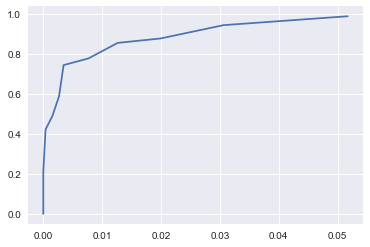

In [56]:
plotter.plot_auc(pipeline, X_test, y_test)

In [57]:
piperoni(RandomForestClassifier(random_state=64))

,Dataset,Cross-Val Mean,Cross-Val Scores,CV sd.
0,Validation,0.978527,"[0.977, 0.981, 0.978]",0.0019
1,Test (hold),0.977487,"[0.979, 0.975, 0.979]",0.0017
2,Baseline,0.966912,,


In [58]:
from imblearn.ensemble import BalancedBaggingClassifier

In [59]:
piperoni(BalancedBaggingClassifier())

,Dataset,Cross-Val Mean,Cross-Val Scores,CV sd.
0,Validation,0.956683,"[0.936, 0.956, 0.973]",0.0136
1,Test (hold),0.951427,"[0.947, 0.940, 0.943]",0.0068
2,Baseline,0.966912,,


In [60]:
model_list = [LogisticRegression(), RandomForestClassifier(), BalancedBaggingClassifier(), 
              ExtraTreeClassifier(), DecisionTreeClassifier()]

[(str(m)[0:str(m).find('(')], "{:.3f}".format(piperoni(m).loc[1, 'Cross-Val Mean'])) for m in model_list]
    

[('LogisticRegression', '0.975'),
 ('RandomForestClassifier', '0.976'),
 ('BalancedBaggingClassifier', '0.942'),
 ('ExtraTreeClassifier', '0.957'),
 ('DecisionTreeClassifier', '0.963')]

## Visualizing
- Let's plot out a comparison to see how each classifier weights each feature
- Dendrogram
...etc

In [61]:
coefdf.head()

,logreg_coef,logreg_abs_coef,rf_coefs
age,0.132785,0.132785,0.004957
g,-0.056209,0.056209,0.002179
gs,0.137461,0.137461,0.006573
mp,-0.015002,0.015002,0.006235
per,0.147430,0.147430,0.030659


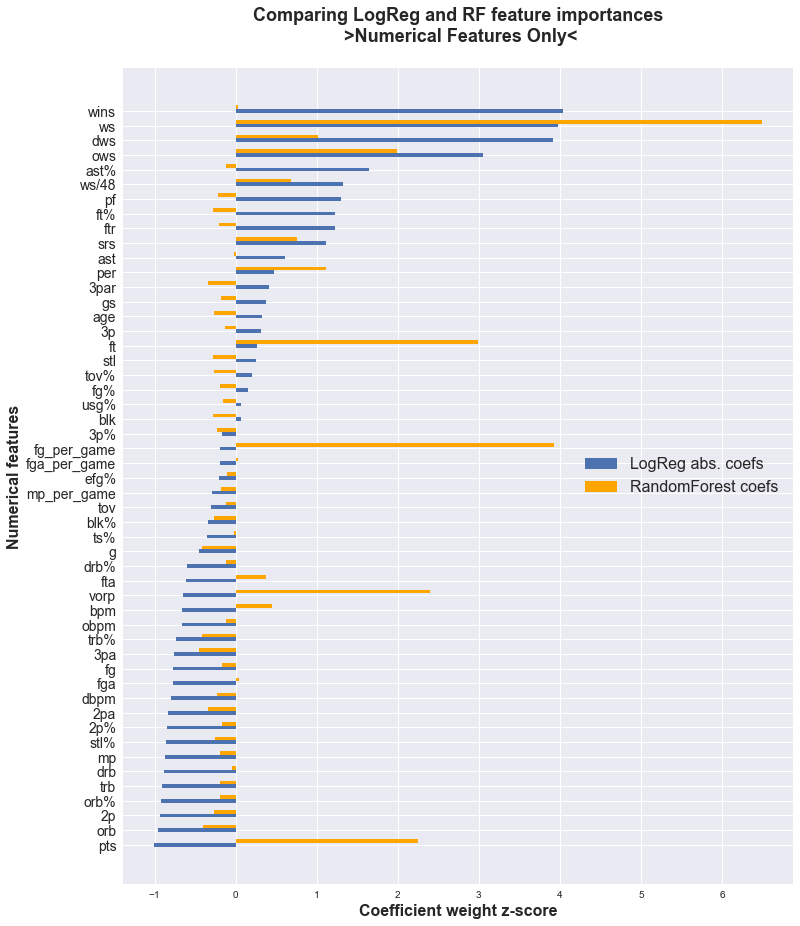

In [62]:
# can only compare LR_abs to RF b/c RF only has weight, not direction
plot_df = norm_coef.loc[num_cols].sort_values(by='logreg_abs_coef', ascending=True)

ticklocs = np.arange(0, plot_df.shape[0])
ticklabels = plot_df.index

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 15));

plt.barh(y = ticklocs, width=plot_df['logreg_abs_coef'],
         label='LogReg abs. coefs', 
        height=0.25);

plt.barh(y = ticklocs+0.25, width=plot_df['rf_coefs'],
         label='RandomForest coefs', 
        height=0.25, color='orange');


plt.yticks(ticklocs, ticklabels, fontsize=13);
plt.tick_params('y', labelsize=14);

plt.ylabel('Numerical features', fontsize=16, weight='bold')
plt.xlabel('Coefficient weight z-score', fontsize=16, weight='bold')

plt.legend(fontsize=16, loc = 'center right');
plt.title('Comparing LogReg and RF feature importances\n >Numerical Features Only<\n', fontsize=18, weight='bold');

**Dendrogram**

In [63]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [64]:
dt = DecisionTreeClassifier(random_state=64)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=64,
            splitter='best')

Decision Tree


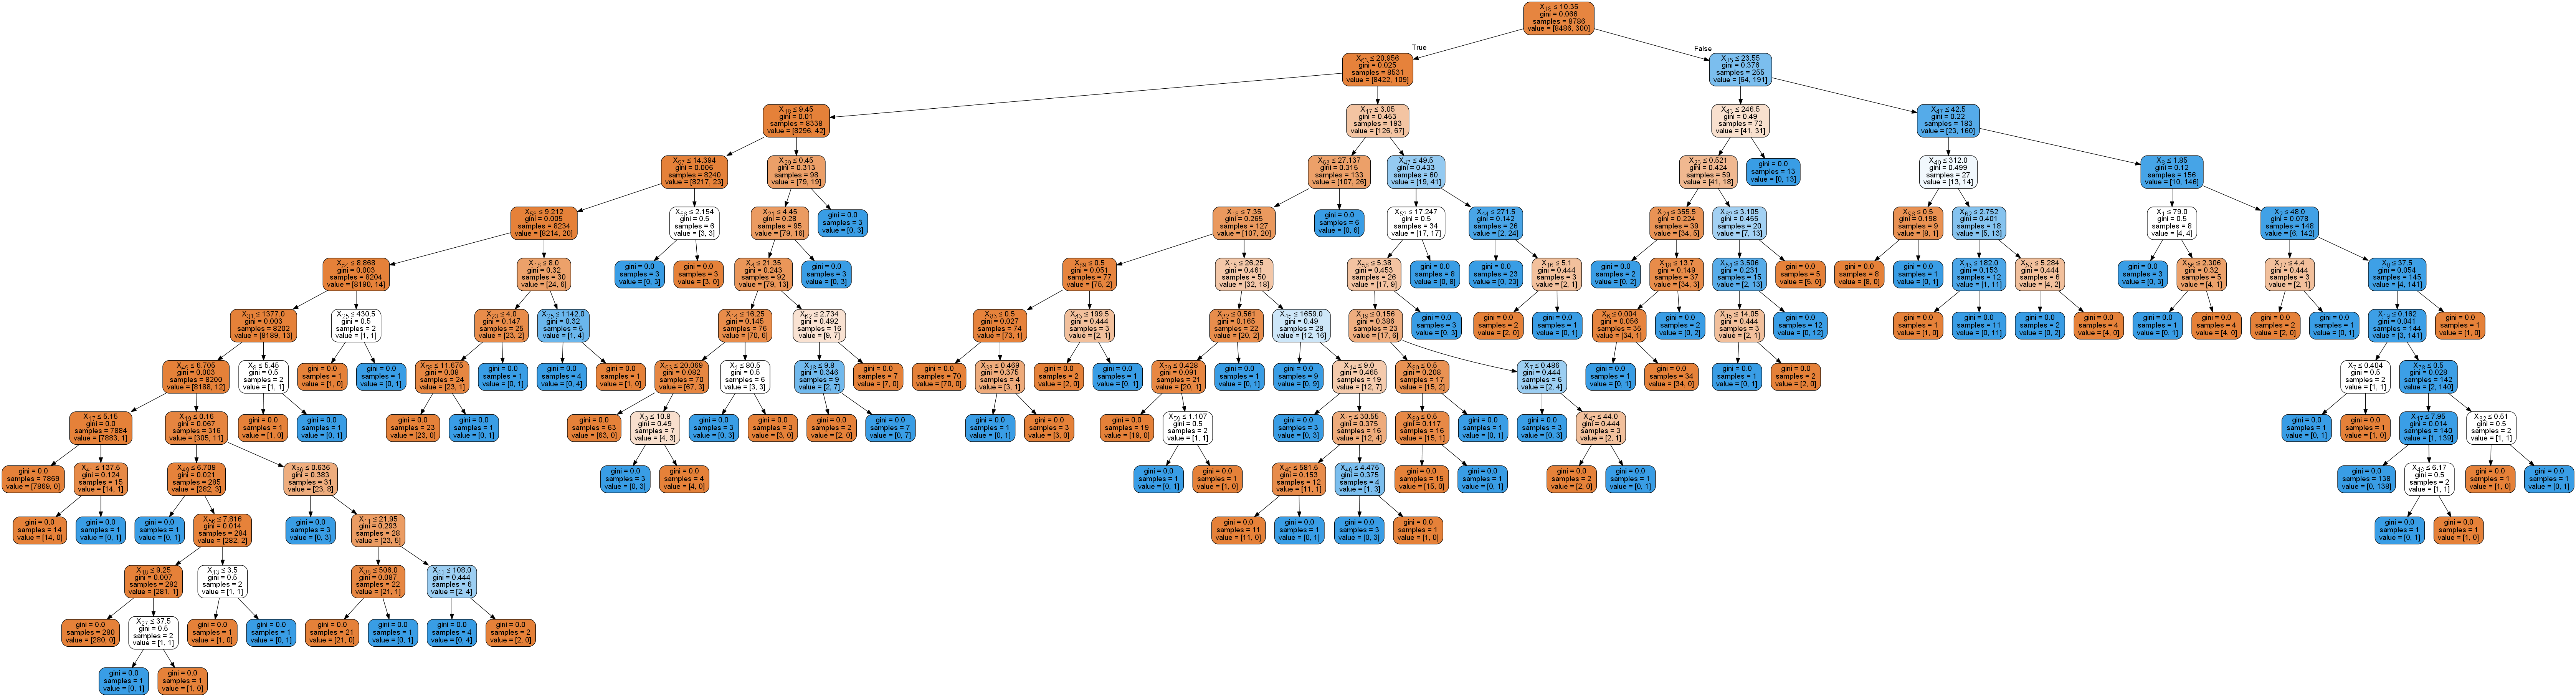

In [65]:
dot_data = StringIO()  

export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
print('Decision Tree')
Image(graph.create_png())  

**Confusion Matrix**

In [66]:
from sklearn.metrics import confusion_matrix

In [67]:
num_cols = list(X_train.columns[:X_train.columns.get_loc('pts_per_game')])

cat_cols = list(X_train.columns[X_train.columns.get_loc('pts_per_game'):])

model = LogisticRegressionCV(random_state=64)

num_pipe = Pipeline([
    ('fe', FeatureExtractor(num_cols)),
    ('ss', StandardScaler())
])

cat_pipe = Pipeline([
    ('fe', FeatureExtractor(cat_cols))
])

pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            
            ('nums', num_pipe),
            
            ('onehots', cat_pipe)
        ])), 
    ('model', model)
])

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('nums', Pipeline(memory=None,
     steps=[('fe', FeatureExtractor(column=['age', 'g', 'gs', 'mp', 'per', 'ts%', '3par', 'ftr', 'orb%', 'drb%', 'trb%', 'ast%', 'stl%', 'blk%', 'tov%', 'usg%', 'ows', 'dws', 'ws', 'ws/48', 'obpm', 'dbpm'...'l2', random_state=64,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0))])

In [68]:
pipeline.named_steps['model']

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=64,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

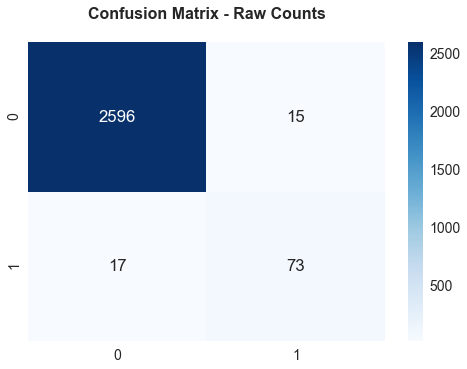

In [69]:
# raw num
sns.set(font_scale=1.4)
sns.heatmap(confusion_matrix(y_test, pipeline.predict(X_test)), cmap='Blues', annot=True, fmt='d');
plt.title('Confusion Matrix - Raw Counts\n', fontsize=16, weight='bold');

In [106]:
conf = pd.DataFrame(confusion_matrix(y_test, pipeline.predict(X_test)),
                   columns = ['predicted_no_award', 'predicted_award'])
conf.apply(lambda x: x/x.sum(), axis=1)

,predicted_no_award,predicted_award
0,0.994255,0.005745
1,0.188889,0.811111


In [107]:
from sklearn.metrics import classification_report

In [108]:
print(classification_report(y_test, pipeline.predict(X_test)))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99      2611
          1       0.83      0.81      0.82        90

avg / total       0.99      0.99      0.99      2701



Total Accuracy: 98.56%


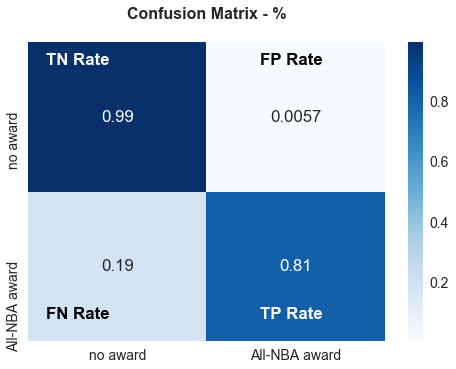

In [113]:
## Confusion Matrix of model two (team data) - but

sns.set(font_scale=1.4)

## create confusion matrix
conf = pd.DataFrame(confusion_matrix(y_test, pipeline.predict(X_test)),
                   columns = ['predicted_no_award', 'predicted_award'])

## create heatmap
sns.heatmap(conf.apply(lambda x: x/x.sum(), axis=1), cmap='Blues', annot=True, 
           xticklabels=['no award', 'All-NBA award'],
           yticklabels=['no award', 'All-NBA award']);

#label conf. matrix
plt.text(x = .1, y = 1.85, s='TN Rate', color='white', weight='bold')
plt.text(x = 1.3, y = 1.85, s='FP Rate', color='black', weight='bold')
plt.text(x = .1, y = .15, s='FN Rate', color='black', weight='bold')
plt.text(x = 1.3, y = .15, s='TP Rate', color='white', weight='bold')

# label things
plt.tick_params(labelsize=14);
plt.title('Confusion Matrix - %\n', fontsize=16, weight='bold');

print('Total Accuracy: ' + "{:.2%}".format(cross_val_score(pipeline, X_test, y_test).mean()))

In [161]:
conf

,predicted_no_award,predicted_award
0,2596,15
1,17,73


In [114]:
print('Validation')
print(cross_val_score(pipeline, X_test, y_test))
print(cross_val_score(pipeline, X_test, y_test).mean())
print()
print('Test')
print(cross_val_score(pipeline, X_hold, y_hold))
print(cross_val_score(pipeline, X_hold, y_hold).mean())

Validation
[0.98668147 0.98777778 0.98222222]
0.985560488346282

Test
[0.9787234  0.96797153 0.97864769]
0.9751142071123898


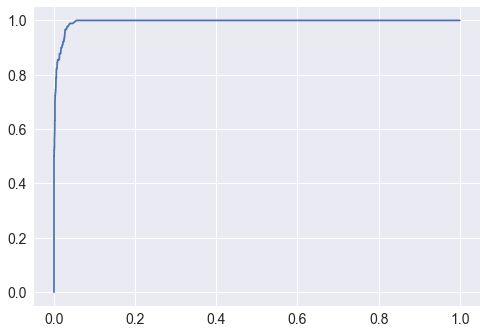

In [71]:
plotter.plot_auc(pipeline, X_test, y_test)

In [72]:
tn, fp, fn, tp = confusion_matrix(y_test, pipeline.predict(X_test)).ravel()

In [73]:
confusion_matrix(y_test, pipeline.predict(X_test)).ravel()

array([2596,   15,   17,   73], dtype=int64)

#### let's make a function

In [74]:
def plot_confusion(estimator, X, y_true):
    """Plots a labeled confusion matrix for binary classification estimators.
    Annotates with %s for TN, FP, FN, TP."""
    
    # set font to be bigger
    sns.set(font_scale=1.4)

    # set your confusion matrix
    conf = confusion_matrix(y_true, estimator.predict(X))/X.shape[0]

    sns.heatmap(conf, cmap='Blues', annot=True, fmt='.1%');

    #label conf. matrix
    plt.text(x = .1, y = 1.85, s='TN', color='gray', weight='bold')
    plt.text(x = 1.8, y = 1.85, s='FP', color='gray', weight='bold')
    plt.text(x = .1, y = .15, s='FN', color='gray', weight='bold')
    plt.text(x = 1.8, y = .15, s='TP', color='gray', weight='bold')

    # label other things
    plt.tick_params(labelsize=14);
    plt.title('Confusion Matrix - %\n', fontsize=16, weight='bold');
    
    print('Total Accuracy: ' + "{:.2%}".format(cross_val_score(estimator, X, y_true).mean()))

Total Accuracy: 98.56%


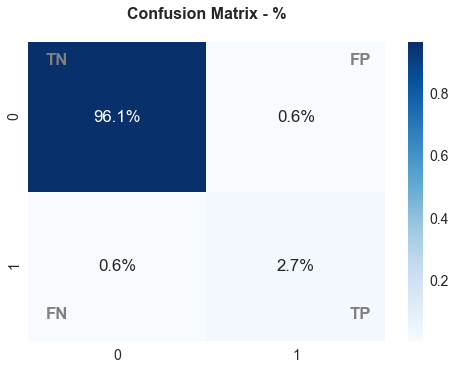

In [102]:
## test data
plot_confusion(pipeline, X_test, y_test)

Total Accuracy: 97.51%


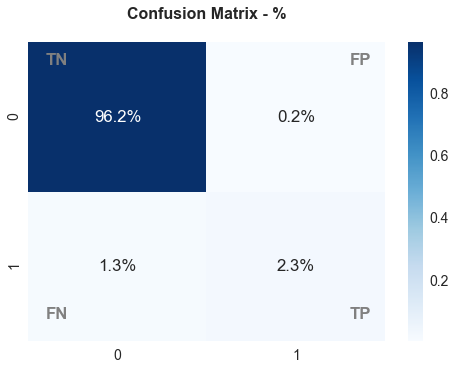

In [103]:
## hold data
plot_confusion(pipeline, X_hold, y_hold)

### Moving on...
- Gotta pull out the actual teams

In [76]:
pd.Series(pipeline.predict_proba(X_test)[:,1])[:10]

0    0.000022
1    0.000007
2    0.000001
3    0.017262
4    0.000003
5    0.000161
6    0.000391
7    0.000062
8    0.000174
9    0.000035
dtype: float64

In [77]:
X_test.shape, y_test.shape

((2701, 101), (2701,))

In [78]:
## make a DF
pred_test_lr1 = pd.concat([model_df.loc[model_df['year'].isin(test_yrs), ['year','player', 'award_tm', 'listed_pos', 'tm_name', 'award_pos']].reset_index(drop=True),
                           X_test, y_test.reset_index(drop=True).reset_index(drop=True), 
                           pd.Series(pipeline.predict_proba(X_test)[:,1])],
                          axis=1).rename(columns={0:'proba'})

In [79]:
pred_test_lr1.head()

,year,player,award_tm,listed_pos,tm_name,award_pos,age,g,gs,mp,per,ts%,3par,ftr,orb%,drb%,trb%,ast%,stl%,blk%,tov%,usg%,ows,dws,ws,ws/48,obpm,dbpm,bpm,vorp,fg,fga,fg%,3p,3pa,3p%,2p,2pa,2p%,efg%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,srs,wins,mp_per_game,fg_per_game,fga_per_game,2p_per_game,2pa_per_game,ft_per_game,fta_per_game,orb_per_game,drb_per_game,trb_per_game,ast_per_game,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game,tm_encode_ATL,tm_encode_BOS,tm_encode_BRK,tm_encode_CHA,tm_encode_CHI,tm_encode_CLE,tm_encode_DAL,tm_encode_DEN,tm_encode_DET,tm_encode_GSW,tm_encode_HOU,tm_encode_IND,tm_encode_LAC,tm_encode_LAL,tm_encode_MEM,tm_encode_MIA,tm_encode_MIL,tm_encode_MIN,tm_encode_NOP,tm_encode_NYK,tm_encode_OKC,tm_encode_ORL,tm_encode_PHI,tm_encode_PHO,tm_encode_POR,tm_encode_SAC,tm_encode_SAS,tm_encode_TOR,tm_encode_TOT,tm_encode_UTA,tm_encode_WAS,pos_encode_C,pos_encode_F,pos_encode_G,conf_encode_East,conf_encode_TOT,conf_encode_West,target,proba
0,1992.0,alaa abdelnaby,0,PF,POR,F,23.0,71.0,1.0,934.0,13.5,0.533,0.000,0.280,9.5,20.9,15.2,4.7,1.3,1.1,14.0,20.6,0.6,1.5,2.1,0.110,-3.0,-0.9,-3.9,-0.5,178.0,361.0,0.493,0.0,0.0,0.000,178.0,361.0,0.493,0.493,76.0,101.0,0.752,81.0,179.0,260.0,30.0,25.0,16.0,66.0,132.0,432.0,6.94,57.0,13.154930,2.507042,5.084507,2.507042,5.084507,1.070423,1.422535,1.140845,2.521127,3.661972,0.422535,0.352113,0.225352,0.929577,1.859155,6.084507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0.000022
1,1992.0,mahmoud abdul-rauf,0,PG,DEN,G,22.0,81.0,11.0,1538.0,12.6,0.469,0.111,0.128,1.5,6.8,4.0,21.0,1.4,0.2,11.6,26.7,-0.2,0.8,0.6,0.018,-1.7,-3.5,-5.2,-1.3,356.0,845.0,0.421,31.0,94.0,0.330,325.0,751.0,0.433,0.440,94.0,108.0,0.870,22.0,92.0,114.0,192.0,44.0,4.0,117.0,130.0,837.0,-7.59,24.0,18.987654,4.395062,10.432099,4.012346,9.271605,1.160494,1.333333,0.271605,1.135802,1.407407,2.370370,0.543210,0.049383,1.444444,1.604938,10.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0.000007
2,1992.0,mark acres,0,C,ORL,C,29.0,68.0,6.0,926.0,10.1,0.576,0.020,0.444,11.4,19.2,15.2,3.2,1.3,1.0,15.5,9.6,1.1,0.8,1.9,0.097,-2.3,0.1,-2.2,-0.1,78.0,151.0,0.517,1.0,3.0,0.333,77.0,148.0,0.520,0.520,51.0,67.0,0.761,97.0,155.0,252.0,22.0,25.0,15.0,33.0,140.0,208.0,-6.52,21.0,13.617647,1.147059,2.220588,1.132353,2.176471,0.750000,0.985294,1.426471,2.279412,3.705882,0.323529,0.367647,0.220588,0.485294,2.058824,3.058824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0.000001
3,1992.0,michael adams,0,PG,WAS,G,29.0,78.0,78.0,2795.0,17.1,0.506,0.313,0.292,2.2,10.1,6.1,31.5,2.5,0.2,13.2,24.2,2.6,2.6,5.3,0.090,2.5,-0.8,1.7,2.6,485.0,1233.0,0.393,125.0,386.0,0.324,360.0,847.0,0.425,0.444,313.0,360.0,0.869,58.0,252.0,310.0,594.0,145.0,9.0,212.0,162.0,1408.0,0.57,35.0,35.833333,6.217949,15.807692,4.615385,10.858974,4.012821,4.615385,0.743590,3.230769,3.974359,7.615385,1.858974,0.115385,2.717949,2.076923,18.051282,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0.017262
4,1992.0,rafael addison,0,SF,BRK,F,27.0,76.0,8.0,1175.0,10.9,0.477,0.113,0.176,5.7,9.3,7.4,8.1,1.2,1.4,9.0,17.5,0.8,0.7,1.5,0.063,-2.3,-1.5,-3.8,-0.5,187.0,432.0,0.433,14.0,49.0,0.286,173.0,383.0,0.452,0.449,56.0,76.0,0.737,65.0,100.0,165.0,68.0,28.0,28.0,46.0,109.0,444.0,4.35,30.0,15.460526,2.460526,5.684211,2.276316,5.039474,0.736842,1.000000,0.855263,1.315789,2.171053,0.894737,0.368421,0.368421,0.605263,1.434211,5.842105,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0.000003


In [80]:
pred_test_lr1.year.unique()

array([1992., 1996., 2001., 2005., 2013., 2017.])

In [81]:
mask = (pred_test_lr1['pos_encode_C'] == 1) & (pred_test_lr1['year'] == 1992)
interestcols = ['year','g', 'player', 'tm_name','award_tm', 'listed_pos', 'target', 'proba']

pred_test_lr1.loc[mask, interestcols].sort_values(by='proba', ascending=False).head(5)

,year,g,player,tm_name,award_tm,listed_pos,target,proba
294,1992.0,68.0,david robinson,SAS,1,C,1,0.993346
112,1992.0,82.0,patrick ewing,NYK,2,C,1,0.978260
84,1992.0,73.0,brad daugherty,CLE,3,C,1,0.877594
251,1992.0,70.0,hakeem olajuwon,HOU,0,C,0,0.805378
110,1992.0,66.0,pervis ellison,WAS,0,C,0,0.294154


In [82]:
mask = (pred_test_lr1['pos_encode_G'] == 1) & (pred_test_lr1['year'] == 1996)

pred_test_lr1.loc[mask, interestcols].sort_values(by='proba', ascending=False).head(10)

,year,g,player,tm_name,award_tm,listed_pos,target,proba
575,1996.0,82.0,michael jordan,CHI,1,SG,1,0.999890
539,1996.0,82.0,anfernee hardaway,ORL,1,PG,1,0.950975
753,1996.0,82.0,john stockton,UTA,2,PG,1,0.588204
426,1996.0,75.0,terrell brandon,CLE,0,PG,0,0.571182
669,1996.0,81.0,gary payton,OKC,2,PG,1,0.409038
755,1996.0,67.0,rod strickland,POR,0,PG,0,0.329469
634,1996.0,76.0,reggie miller,IND,3,SG,1,0.223097
569,1996.0,56.0,kevin johnson,PHO,0,PG,0,0.189750
565,1996.0,82.0,avery johnson,SAS,0,PG,0,0.122906
700,1996.0,81.0,mitch richmond,SAC,3,SG,1,0.111382


In [83]:
mask = (pred_test_lr1['pos_encode_F'] == 1) & (pred_test_lr1['year'] == 1996)

pred_test_lr1.loc[mask, interestcols].sort_values(by='proba', ascending=False).head(15)

,year,g,player,tm_name,award_tm,listed_pos,target,proba
610,1996.0,82.0,karl malone,UTA,1,PF,1,0.990410
682,1996.0,77.0,scottie pippen,CHI,1,SF,1,0.901748
550,1996.0,80.0,grant hill,DET,2,SF,1,0.824967
407,1996.0,71.0,charles barkley,PHO,3,PF,1,0.749311
578,1996.0,79.0,shawn kemp,OKC,2,PF,1,0.587252
570,1996.0,81.0,larry johnson,CHA,0,PF,0,0.420423
449,1996.0,78.0,cedric ceballos,LAL,0,SF,0,0.252288
619,1996.0,82.0,anthony mason,NYK,0,SF,0,0.160182
501,1996.0,77.0,sean elliott,SAS,0,SF,0,0.112225
698,1996.0,79.0,glen rice,CHA,0,SF,0,0.103243


### 2017

In [84]:
## Guards
mask = (pred_test_lr1['pos_encode_G'] == 1) & (pred_test_lr1['year'] == 2017)

pred_test_lr1.loc[mask, interestcols].sort_values(by='proba', ascending=False).head(10)

,year,g,player,tm_name,award_tm,listed_pos,target,proba
2672,2017.0,81.0,russell westbrook,OKC,1,PG,1,0.999822
2386,2017.0,81.0,james harden,HOU,1,PG,1,0.999525
2312,2017.0,79.0,stephen curry,GSW,2,PG,1,0.980376
2638,2017.0,76.0,isaiah thomas,BOS,2,PG,1,0.964373
2666,2017.0,78.0,john wall,WAS,3,PG,1,0.842582
2480,2017.0,75.0,damian lillard,POR,0,PG,0,0.799333
2322,2017.0,74.0,demar derozan,TOR,3,SG,1,0.776203
2488,2017.0,60.0,kyle lowry,TOR,0,PG,0,0.608776
2429,2017.0,72.0,kyrie irving,CLE,0,PG,0,0.592891
2565,2017.0,61.0,chris paul,LAC,0,PG,0,0.576756


In [85]:
## Forwards
mask = (pred_test_lr1['pos_encode_F'] == 1) & (pred_test_lr1['year'] == 2017)

pred_test_lr1.loc[mask, interestcols].sort_values(by='proba', ascending=False).head(10)

,year,g,player,tm_name,award_tm,listed_pos,target,proba
2434,2017.0,74.0,lebron james,CLE,1,SF,1,0.996207
2333,2017.0,62.0,kevin durant,GSW,2,SF,1,0.987839
2475,2017.0,74.0,kawhi leonard,SAS,1,SF,1,0.971165
2230,2017.0,80.0,giannis antetokounmpo,MIL,2,SF,1,0.903399
2280,2017.0,76.0,jimmy butler,CHI,3,SF,1,0.871873
2399,2017.0,73.0,gordon hayward,UTA,0,SF,0,0.435919
2382,2017.0,61.0,blake griffin,LAC,0,PF,0,0.386654
2364,2017.0,75.0,paul george,IND,0,SF,0,0.124937
2221,2017.0,72.0,lamarcus aldridge,SAS,0,PF,0,0.097731
2378,2017.0,76.0,draymond green,GSW,3,PF,1,0.060076


In [86]:
## Centers
maskyear = 2017
maskpos = 'C'

mask = (pred_test_lr1['pos_encode_'+maskpos] == 1) & (pred_test_lr1['year'] == maskyear)

pred_test_lr1.loc[mask, interestcols].sort_values(by='proba', ascending=False).head(6)

,year,g,player,tm_name,award_tm,listed_pos,target,proba
2314,2017.0,75.0,anthony davis,NOP,1,C,1,0.965670
2647,2017.0,82.0,karl-anthony towns,MIN,0,C,0,0.887287
2369,2017.0,81.0,rudy gobert,UTA,2,C,1,0.796976
2304,2017.0,72.0,demarcus cousins,TOT,0,C,0,0.756211
2454,2017.0,81.0,deandre jordan,LAC,3,C,1,0.515307
2675,2017.0,77.0,hassan whiteside,MIA,0,C,0,0.346156


### Model Tune up  
**Doing some GridSearchCV-ing**

In [1]:
# from sklearn.model_selection import GridSearchCV

# pipeline.named_steps

# params = {
#     'model': [LogisticRegression(random_state=64)],
#     'model__class_weight': [None, 'balanced'],
# #     'model__solver': ['liblinear', 'lbfgs'],
# #     'model__C': [0.2, 0.6, 1.0]
# }

# gs_logreg = GridSearchCV(pipeline, param_grid=params, scoring='accuracy', n_jobs=-1)

In [2]:
# gs_logreg.fit(X_train, y_train)

## Here's where we put all of our predictions together

In [103]:
pred_names = pd.DataFrame()

for year in pred_test_lr1['year'].unique():
    for pos in model_df.award_pos.unique():
#         print(year, 'pos_encode_'+pos)
        
        maskyear = year
        maskpos = pos

        mask = (pred_test_lr1['pos_encode_'+maskpos] == 1) & (pred_test_lr1['year'] == maskyear)
        
        
        ## control flow:
        if maskpos != 'C':
        
#             print(pred_test_lr1.loc[mask, ['year', 'player', 'proba']].sort_values(by='proba', ascending=False).head(6))
#             print()
            pred_names = pred_names.append(pred_test_lr1.loc[mask, ['year', 'player', 'award_pos','proba', 'target']].sort_values(by='proba', ascending=False).head(6))
                    
        else:
#             print(pred_test_lr1.loc[mask, ['year', 'player', 'proba']].sort_values(by='proba', ascending=False).head(3))
#             print()
            pred_names = pred_names.append(pred_test_lr1.loc[mask, ['year', 'player', 'award_pos','proba', 'target']].sort_values(by='proba', ascending=False).head(3))

        
pred_names = pred_names.reset_index(drop=True)
pred_names.head()

,year,player,award_pos,proba,target
0,1992.0,patrick ewing,C,0.9,1
1,1992.0,david robinson,C,0.8,1
2,1992.0,brad daugherty,C,0.8,1
3,1992.0,michael jordan,G,1.0,1
4,1992.0,john stockton,G,0.9,1


In [104]:
pred_award_pos = [1, 2, 3, 1, 1, 2, 2, 3, 3, 1, 1, 2, 2, 3, 3] * pred_names.year.nunique()
pred_names['pred_award_pos'] = pred_award_pos

In [105]:
## need to make a binary flag as well as a year-player column
pred_names['year-player'] = pred_names['year'].astype(str) + pred_names['player']
pred_names['predicted'] = 1

In [106]:
pred_names.head()

,year,player,award_pos,proba,target,pred_award_pos,year-player,predicted
0,1992.0,patrick ewing,C,0.9,1,1,1992.0patrick ewing,1
1,1992.0,david robinson,C,0.8,1,2,1992.0david robinson,1
2,1992.0,brad daugherty,C,0.8,1,3,1992.0brad daugherty,1
3,1992.0,michael jordan,G,1.0,1,1,1992.0michael jordan,1
4,1992.0,john stockton,G,0.9,1,1,1992.0john stockton,1


In [107]:
## saving progress
pred_names.to_csv('./data/pred_names.csv', index=False)

In [108]:
player_compare_cols = list(pred_test_lr2.columns[0:pred_test_lr2.columns.get_loc('fg')]) +  ['fg%', '3p%', '2p%', 'efg%', 'ft%'] + list(pred_test_lr2.columns[pred_test_lr2.columns.get_loc('mp_per_game'):])

In [109]:
## Need to compare this.

brad_hakeem = pred_test_lr2.loc[(pred_test_lr2.year == 1992) & (pred_test_lr2.player.isin(['brad daugherty', 'hakeem olajuwon'])),
                  player_compare_cols].T

brad_hakeem.join(coef_compare['coef']).sort_values(by='coef', ascending=False).rename(columns={84:'brad', 251: 'hakeem'})

,brad,hakeem,coef
ws,11.7,9.8,1.455713
ows,8.2,4.2,1.108357
mp,2643,2636,1.075516
dws,3.5,5.6,0.853270
fta_per_game,7.30137,6.11429,0.799627
ast_per_game,3.58904,2.24286,0.609618
dbpm,1.1,4.3,0.428611
fg%,0.57,0.502,0.399764
2p_per_game,7.89041,8.44286,0.394257
ws/48,0.213,0.178,0.337694


**Answer:** Win shares (primarily OWS), and fouls/game (neg)

## Save model to disk!

In [110]:
pipeline.named_steps['model']

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=64, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [87]:
# save the model to disk
import pickle
from sklearn.externals import joblib
filename = 'logreg_team.pkl'
pickle.dump(pipeline, open(filename, 'wb'))
# joblib.dump(pipeline, filename)

In [88]:
print(cross_val_score(pipeline, X_hold, y_hold))
print(cross_val_score(pipeline, X_hold, y_hold).mean())

[0.9787234  0.96797153 0.97864769]
0.9751142071123898


In [113]:
# ## save CSVs
# X_train.to_csv('./data/X_train_v2.csv', index=False)
# X_test.to_csv('./data/X_test_v2.csv', index=False)
# X_hold.to_csv('./data/X_hold_v2.csv', index=False)

# y_train.to_csv('./data/y_train_v2.csv', index=False)
# y_test.to_csv('./data/y_test_v2.csv', index=False)
# y_hold.to_csv('./data/y_hold_v2.csv', index=False)

# model_df.to_csv('./data/model_df.csv', index=False)

In [89]:
## Make probas for all of them
X_train['probas'] = pipeline.predict_proba(X_train)[:,1]
X_test['probas'] = pipeline.predict_proba(X_test)[:,1]
X_hold['probas'] = pipeline.predict_proba(X_hold)[:,1]

In [94]:
## make a DF
pred_train = pd.concat([model_df.loc[model_df['year'].isin(train_yrs)].reset_index(drop=True),
                                     X_train[['probas']]], axis=1)

pred_test_full = pd.concat([model_df.loc[model_df['year'].isin(test_yrs)].reset_index(drop=True),
                           X_test[['probas']]], axis=1)

pred_hold = pd.concat([model_df.loc[model_df['year'].isin(hold_yrs)].reset_index(drop=True),
                           X_hold[['probas']]], axis=1)

In [95]:
# Make mega-DF
pred_full = pd.concat([pred_train, pred_test_full, pred_hold])

In [96]:
pred_full.head()

,year,player,listed_pos,age,tm_name,g,gs,mp,per,ts%,3par,ftr,orb%,drb%,trb%,ast%,stl%,blk%,tov%,usg%,ows,dws,ws,ws/48,obpm,dbpm,bpm,vorp,fg,fga,fg%,3p,3pa,3p%,2p,2pa,2p%,efg%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,year-player,award_tm,award_pos,year-team,conference,losses,srs,wins,target,mp_per_game,fg_per_game,fga_per_game,2p_per_game,2pa_per_game,ft_per_game,fta_per_game,orb_per_game,drb_per_game,trb_per_game,ast_per_game,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game,probas
0,1989.0,kareem abdul-jabbar,C,41.0,LAL,74.0,74.0,1695.0,12.9,0.511,0.005,0.250,7.3,14.2,11.0,6.1,1.1,2.9,11.5,20.1,0.9,2.0,2.9,0.082,-2.3,0.0,-2.3,-0.1,313.0,659.0,0.475,0.0,3.0,0.000,313.0,656.0,0.477,0.475,122.0,165.0,0.739,103.0,231.0,334.0,74.0,38.0,85.0,95.0,196.0,748.0,1989.0kareem abdul-jabbar,0,C,1989.0LAL,West,25.0,6.38,57.0,0,22.905405,4.229730,8.905405,4.229730,8.864865,1.648649,2.229730,1.391892,3.121622,4.513514,1.000000,0.513514,1.148649,1.283784,2.648649,10.108108,0.000613
1,1989.0,mark acres,C,26.0,BOS,62.0,0.0,632.0,8.2,0.507,0.009,0.421,10.9,15.6,13.3,3.7,1.5,0.6,14.5,10.4,0.4,0.5,0.9,0.066,-2.1,-0.4,-2.5,-0.1,55.0,114.0,0.482,1.0,1.0,1.000,54.0,113.0,0.478,0.487,26.0,48.0,0.542,59.0,87.0,146.0,19.0,19.0,6.0,23.0,94.0,137.0,1989.0mark acres,0,C,1989.0BOS,East,40.0,1.26,42.0,0,10.193548,0.887097,1.838710,0.870968,1.822581,0.419355,0.774194,0.951613,1.403226,2.354839,0.306452,0.306452,0.096774,0.370968,1.516129,2.209677,0.000001
2,1989.0,michael adams,PG,26.0,DEN,77.0,77.0,2787.0,17.5,0.567,0.431,0.363,2.5,8.3,5.2,22.2,2.7,0.2,12.5,19.7,5.4,2.9,8.3,0.143,3.8,-0.6,3.2,3.7,468.0,1082.0,0.433,166.0,466.0,0.356,302.0,616.0,0.490,0.509,322.0,393.0,0.819,71.0,212.0,283.0,490.0,166.0,11.0,180.0,149.0,1424.0,1989.0michael adams,0,G,1989.0DEN,West,38.0,0.91,44.0,0,36.194805,6.077922,14.051948,3.922078,8.000000,4.181818,5.103896,0.922078,2.753247,3.675325,6.363636,2.155844,0.142857,2.337662,1.935065,18.493506,0.048652
3,1989.0,mark aguirre,SF,29.0,TOT,80.0,76.0,2597.0,16.4,0.524,0.137,0.309,6.4,10.0,8.3,17.9,0.9,0.8,12.6,27.4,2.4,2.1,4.5,0.082,1.7,-1.2,0.5,1.7,586.0,1270.0,0.461,51.0,174.0,0.293,535.0,1096.0,0.488,0.481,288.0,393.0,0.733,146.0,240.0,386.0,278.0,45.0,36.0,208.0,229.0,1511.0,1989.0mark aguirre,0,F,1989.0TOT,TOT,48.0,0.19,34.0,0,32.462500,7.325000,15.875000,6.687500,13.700000,3.600000,4.912500,1.825000,3.000000,4.825000,3.475000,0.562500,0.450000,2.600000,2.862500,18.887500,0.006872
4,1989.0,danny ainge,PG,29.0,TOT,73.0,54.0,2377.0,18.0,0.554,0.290,0.228,3.3,8.7,6.0,25.3,1.9,0.2,11.1,22.6,5.2,1.4,6.7,0.135,4.0,-1.6,2.3,2.6,480.0,1051.0,0.457,116.0,305.0,0.380,364.0,746.0,0.488,0.512,205.0,240.0,0.854,71.0,184.0,255.0,402.0,93.0,8.0,145.0,186.0,1281.0,1989.0danny ainge,0,G,1989.0TOT,TOT,46.0,2.91,36.0,0,32.561644,6.575342,14.397260,4.986301,10.219178,2.808219,3.287671,0.972603,2.520548,3.493151,5.506849,1.273973,0.109589,1.986301,2.547945,17.547945,0.011307


In [97]:
## save it!
pred_full.to_csv('./data/pred_full_team.csv', index=False)

### More Feature Importance

In [99]:
## Absolute
coefdf['logreg_coef'].map(lambda x: abs(x)).sort_values(ascending=False).head()

wins            0.500099
ws              0.493660
dws             0.488162
ows             0.402216
pts_per_game    0.297257
Name: logreg_coef, dtype: float64

In [100]:
## Top Pos
coefdf['logreg_coef'].sort_values(ascending=False).head(10)

wins            0.500099
ws              0.493660
dws             0.488162
ows             0.402216
pts_per_game    0.297257
ast%            0.263508
ast_per_game    0.262249
ws/48           0.232364
ftr             0.222168
srs             0.210741
Name: logreg_coef, dtype: float64

In [101]:
## Top Neg
coefdf['logreg_coef'].sort_values(ascending=True).head(10)

pf              -0.229238
ft%             -0.222290
pf_per_game     -0.161352
tm_encode_ATL   -0.152776
3par            -0.141818
ft              -0.127080
stl             -0.125407
tm_encode_BOS   -0.107056
tm_encode_DEN   -0.099275
pos_encode_F    -0.093952
Name: logreg_coef, dtype: float64

Index(['pf', 'ft%', 'pf_per_game', 'tm_encode_ATL', '3par', 'pts_per_game',
       'ows', 'dws', 'ws', 'wins'],
      dtype='object')

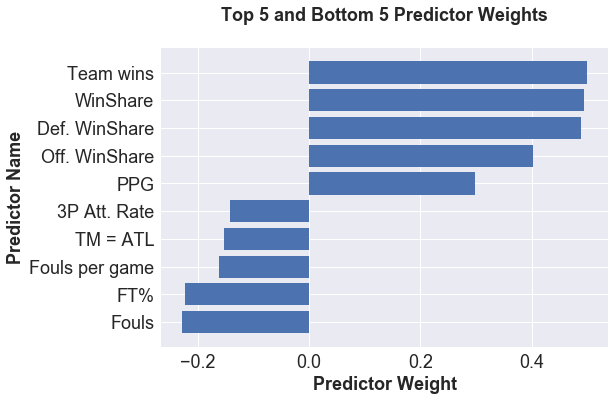

In [160]:
top_feats = coefdf['logreg_coef'].sort_values(ascending=False).head()
bottom_feats = coefdf['logreg_coef'].sort_values(ascending=True).head()

all_feats = bottom_feats.append(top_feats[::-1])

feats_labels = ['Fouls', 'FT%', 'Fouls per game', 'TM = ATL', '3P Att. Rate', 
                'PPG', 'Off. WinShare', 'Def. WinShare', 'WinShare', 
                'Team wins']

plt.barh(y = feats_labels, width=all_feats);

plt.xlabel('Predictor Weight', fontsize=18, weight='bold');
plt.ylabel('Predictor Name', fontsize=18, weight='bold');

plt.tick_params(labelsize=18);

plt.title('Top 5 and Bottom 5 Predictor Weights\n', 
          fontsize=18, weight='bold');

### Some more model visualization

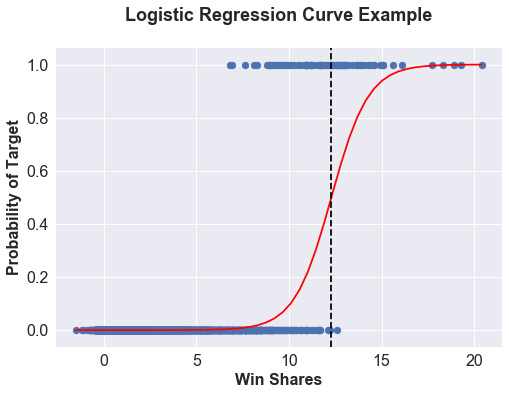

In [145]:
ws_coef = coefdf['logreg_coef'].sort_values(ascending=False)['ws']

intercept = pipeline.named_steps['model'].intercept_[0]

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

plt.scatter(X_test['ws'], pipeline.predict(X_test));

ws_range = np.linspace(np.min(X_test['ws']), np.max(X_test['ws']), )
plt.plot(ws_range, [sigmoid(val + intercept) for val in ws_range], color='red');
# plt.axhline(y=0.5, color='k', linestyle='dashed');
plt.axvline(x=12.29, color='k', linestyle='dashed');
plt.tick_params(labelsize=16);
plt.xlabel('Win Shares', fontsize=16, weight='bold');
plt.ylabel('Probability of Target', fontsize=16, weight='bold');
plt.title('Logistic Regression Curve Example\n', fontsize=18, weight='bold');

## NEXT STEPS
1. Make giant DF of `X_train` + `X_test` + `X_hold` together (all years)
2. Make predictions and predict_probas on them
3. Save DF to reload in "Analysis and Takeaways"

## Link to [Analysis and Takeaways v2](Analysis%20and%20Takeaways_v2.ipynb)